# Analisis Sentimen Ulasan Aplikasi ELSA SPEAK

Proyek ini bertujuan untuk menganalisis sentimen pengguna ELSA SPEAK berdasarkan ulasan dan feedback yang diberikan oleh pengguna platform. Dengan menggunakan teknik analisis sentimen berbasis pembelajaran mesin, proyek ini akan mengidentifikasi perasaan positif, negatif, atau netral yang terkandung dalam ulasan pengguna mengenai pengalaman user dalam menggunakan aplikasi untuk melatih kemampuan berbicara dalam bahasa Inggris.

Metode yang digunakan dalam proyek ini mencakup pembersihan data, tokenisasi, serta penerapan model klasifikasi teks seperti  SVM dan RF untuk mengkategorikan sentimen.


## 1. Import Library

In [20]:
!pip install Sastrawi
!pip install wordcloud
!pip install tqdm

In [21]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud
import nltk



## 2. Memuat Data Hasil Scraping

In [22]:
data = pd.read_csv('/content/reviews.csv')
data.head()

,userName,at,score,content,reviewId
0,Pengguna Google,2025-04-24 02:52:31,1,sekarang berbayar semua,33226353-5e51-4cdb-a61a-43c0bebf3170
1,Pengguna Google,2025-04-23 03:31:12,3,"sejauh ini apknya baguss bagus ajaa, semoga ke...",bcb28cd3-cb68-4a05-9879-19979875560c
2,Pengguna Google,2025-04-22 20:31:38,5,good,a29c65d8-62b2-4943-bd5f-bdd8fddf88ae
3,Pengguna Google,2025-04-21 14:49:28,5,aplikasi yang sangat luar biasa bisa membantu ...,472f0e79-01e8-4fe8-8da1-7cddc917004d
4,Pengguna Google,2025-04-21 06:11:32,5,very good aplication,e39bbf3a-eef0-4d7f-9699-02ff1c33a83f


In [23]:
# membuat data frame dengan kolom yang diperlukan
df = pd.DataFrame(data[['content', 'score']])
df.head()

,content,score
0,sekarang berbayar semua,1
1,"sejauh ini apknya baguss bagus ajaa, semoga ke...",3
2,good,5
3,aplikasi yang sangat luar biasa bisa membantu ...,5
4,very good aplication,5


## 3. Exploratory Data Analysis (EDA)

In [24]:
# memahami struktur data nya
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6101 entries, 0 to 6100
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  6101 non-null   object
 1   score    6101 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 95.5+ KB


data yang akan di analisis terdapat 6101 baris dengan kolom (content, score)

In [25]:
# Cek missing value
df.isnull().sum().sort_values(ascending=False)

,0
content,0
score,0


In [26]:
# cek duplicate data
df.duplicated().sum()

np.int64(1839)

## 4. Preprocessing Data

In [27]:
# Menghapus data yang duplicate c
df.drop_duplicates(keep='first', inplace=True)

In [28]:
# cek duplicate data setelah drop duplicate
df.duplicated().sum()

np.int64(0)

In [29]:
# Fungsi untuk membersihkan teks
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Hapus URL
    text = re.sub(r'\@\w+|\#', '', text)  # Hapus mention dan hashtag
    text = re.sub(r'\d+', '', text)  # Hapus angka
    text = text.lower()  # Ubah ke huruf kecil
    return text

# Ganti 'review' dengan nama kolom yang benar jika berbeda
df['content'] = df['content'].apply(clean_text)
print(df['content'].head().to_markdown())

|    | content                                                                               |
|---:|:--------------------------------------------------------------------------------------|
|  0 | sekarang berbayar semua                                                               |
|  1 | sejauh ini apknya baguss bagus ajaa, semoga kedepannya masi sesuai ekspetasi aja sihh |
|  2 | good                                                                                  |
|  3 | aplikasi yang sangat luar biasa bisa membantu belajar bahasa inggris sendiri          |
|  4 | very good aplication                                                                  |


In [30]:
# cek data setelah drop duplicate
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4262 entries, 0 to 6100
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  4262 non-null   object
 1   score    4262 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 99.9+ KB


terdapat 4262 baris setelah dilakukan preprocessing data

In [31]:
df.head()

,content,score
0,sekarang berbayar semua,1
1,"sejauh ini apknya baguss bagus ajaa, semoga ke...",3
2,good,5
3,aplikasi yang sangat luar biasa bisa membantu ...,5
4,very good aplication,5


**Hilangkan kata yang tidak baku**

In [32]:
import pandas as pd
import re
from tqdm import tqdm  # Import tqdm

# Enable progress_apply in pandas
tqdm.pandas()

# Kamus slang, dialek, dan singkatan yang akan diubah ke bentuk baku
slang_dialect_dict = {
    'gak': 'tidak',
    'nggak': 'tidak',
    'dng': 'dengan',
    'mantep': 'mantap',
    'mantab': 'mantap',
    'baguss': 'bagus',
    'trs': 'terus',
    'bgt': 'banget',
    'dong': 'sudah',
    'aja': 'saja',
    'kalo': 'kalau',
    'nanya': 'bertanya',
    'nih': 'ini',
    'gini': 'begini',
    'lbh': 'lebih',
    'udh': 'sudah',
    'lumayan': 'cukup',
    'spt': 'seperti',
    'dr': 'dari',
    'jd': 'jadi',
    'ga': 'tidak',
    'dpt': 'dapat',
    'sm': 'sama',
    'btw': 'by the way',
    'gercep': 'gerak cepat',
    'brngnya': 'barang nya',
    'dgn': 'dengan',
    'pd': 'pada',
    'gambr': 'gambar',
    'dtang': 'datang',
    'peyot': 'penyok',
    'penyot': 'penyok',
    'bagis': 'bagus',
    'lengkapsafngat': 'lengkap sangat',
    'anakku': 'anak aku',
    'sukaa': 'suka',
    'lengkaptapi': 'lengkap tapi',
    'diinginkanbarang': 'diinginkan barang',
    'lengkaphanya': 'lengkap hanya',
    'ajadi': 'jadi',
    'good': 'bagus',
    'yg': 'yang',
    'thx': 'terima kasih',
    'makasi': 'terima kasih',
    'terimakasih': 'terima kasih',
    'peny0k': 'penyok',
    'mantul': 'mantap betul',
    'sukak': 'suka',
    'ndak': 'tidak',
    'sedek': 'sedikit',
    'capcus': 'cepat pergi',
    'wuenak': 'enak',
    'sampean': 'kamu',
    'ora': 'tidak',
    'makasi': 'terima kasih',
    'sakno': 'kasihan',
    'mangan': 'makan',
    'ngibul': 'bohong',
    'murudul': 'rontok',
    'brudul': 'rontok',
    'brodol': 'rontok',
    'emang': 'memang',
    'kek': 'seperti',
    'pengen': 'ingin',
    'pas': 'ketika',
    'yaudahlah': 'ya sudah lah',
    'beres': 'selesai',
    'seneng': 'senang',
    'makasih': 'terima kasih',
    'gk tau': 'tidak tahu',
}

# Fungsi untuk mengganti slang dan dialek
def replace_slang_dialect(sentence):
    words = sentence.split()
    replaced_words = [slang_dialect_dict.get(word.lower(), word) for word in words]
    return ' '.join(replaced_words)

# Misalkan DataFrame df memiliki kolom 'content'
df['normalized_content'] = df['content'].progress_apply(replace_slang_dialect)

# Menampilkan hasil
print(df[['normalized_content']].head(20).to_markdown())
print(df[['normalized_content']].tail(10).to_markdown())


100%|██████████| 4262/4262 [00:00<00:00, 450677.52it/s]

|    | normalized_content                                                                                                                                                                                                  |
|---:|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  0 | sekarang berbayar semua                                                                                                                                                                                             |
|  1 | sejauh ini apknya bagus bagus ajaa, semoga kedepannya masi sesuai ekspetasi saja sihh                                                                                                                               |
|  2 | bagus                                                                                                        

In [33]:
df['content'] = df['normalized_content']
df.drop('normalized_content', axis=1, inplace=True)
df.head()

,content,score
0,sekarang berbayar semua,1
1,"sejauh ini apknya bagus bagus ajaa, semoga ked...",3
2,bagus,5
3,aplikasi yang sangat luar biasa bisa membantu ...,5
4,very bagus aplication,5


## 5. Tokenize

In [35]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('indonesian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
def tokenize(text):
    return word_tokenize(text)

df['tokenize'] = df['content'].apply(lambda x: tokenize(x))
df.head()

,content,score,tokenize
0,sekarang berbayar semua,1,"[sekarang, berbayar, semua]"
1,"sejauh ini apknya bagus bagus ajaa, semoga ked...",3,"[sejauh, ini, apknya, bagus, bagus, ajaa, ,, s..."
2,bagus,5,[bagus]
3,aplikasi yang sangat luar biasa bisa membantu ...,5,"[aplikasi, yang, sangat, luar, biasa, bisa, me..."
4,very bagus aplication,5,"[very, bagus, aplication]"


In [37]:
def remove_stopwords(text):
  return [word for word in text if word not in stop_words]

df['stopword removal'] = df['tokenize'].apply(lambda x: remove_stopwords(x))
df.head(5)

,content,score,tokenize,stopword removal
0,sekarang berbayar semua,1,"[sekarang, berbayar, semua]",[berbayar]
1,"sejauh ini apknya bagus bagus ajaa, semoga ked...",3,"[sejauh, ini, apknya, bagus, bagus, ajaa, ,, s...","[apknya, bagus, bagus, ajaa, ,, semoga, kedepa..."
2,bagus,5,[bagus],[bagus]
3,aplikasi yang sangat luar biasa bisa membantu ...,5,"[aplikasi, yang, sangat, luar, biasa, bisa, me...","[aplikasi, membantu, belajar, bahasa, inggris]"
4,very bagus aplication,5,"[very, bagus, aplication]","[very, bagus, aplication]"


## 6. Steaming Data

In [38]:
!pip install Sastrawi

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

In [39]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(text):
    return [stemmer.stem(word) for word in text]

df['stemming'] = df['stopword removal'].apply(lambda x: ' '.join(stemming(x)))
df.head()

,content,score,tokenize,stopword removal,stemming
0,sekarang berbayar semua,1,"[sekarang, berbayar, semua]",[berbayar],bayar
1,"sejauh ini apknya bagus bagus ajaa, semoga ked...",3,"[sejauh, ini, apknya, bagus, bagus, ajaa, ,, s...","[apknya, bagus, bagus, ajaa, ,, semoga, kedepa...",apknya bagus bagus ajaa moga depan mas sesuai...
2,bagus,5,[bagus],[bagus],bagus
3,aplikasi yang sangat luar biasa bisa membantu ...,5,"[aplikasi, yang, sangat, luar, biasa, bisa, me...","[aplikasi, membantu, belajar, bahasa, inggris]",aplikasi bantu ajar bahasa inggris
4,very bagus aplication,5,"[very, bagus, aplication]","[very, bagus, aplication]",very bagus aplication


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4262 entries, 0 to 6100
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   content           4262 non-null   object
 1   score             4262 non-null   int64 
 2   tokenize          4262 non-null   object
 3   stopword removal  4262 non-null   object
 4   stemming          4262 non-null   object
dtypes: int64(1), object(4)
memory usage: 199.8+ KB


In [42]:
# hasil preprocessing data
df.to_csv('hasil_preprocessing.csv', encoding='utf8', index=False)

## 7. WORDCLOUD SETELAH PREPROCESSING

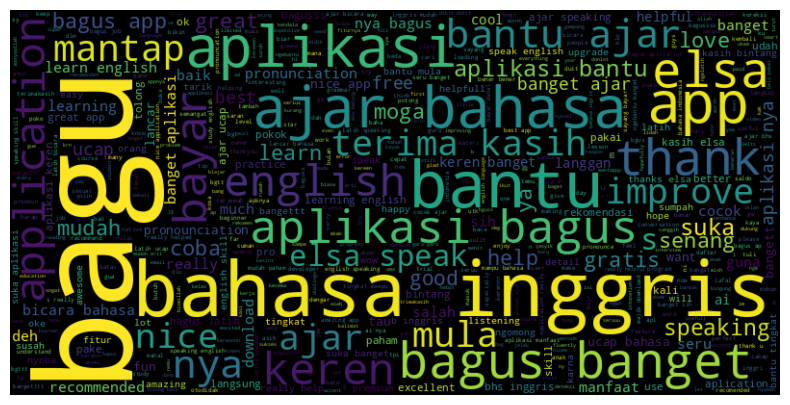

In [48]:
import pandas as pd
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib import pyplot as plt

# Mengisi nilai NaN dengan string kosong ('')
# df['stemming'] = df['stemming'].fillna('')

# Menggabungkan text dari kolom "content"
text = ' '.join(df['stemming'].astype(str).tolist())

stopwords = set(STOPWORDS)
stopwords.update(['https', 'co', 'apk', 'RT', '...', 'amp'])

wordcloud = WordCloud(stopwords=stopwords, background_color='black', max_words=500, width=800, height=400)
wordcloud.generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


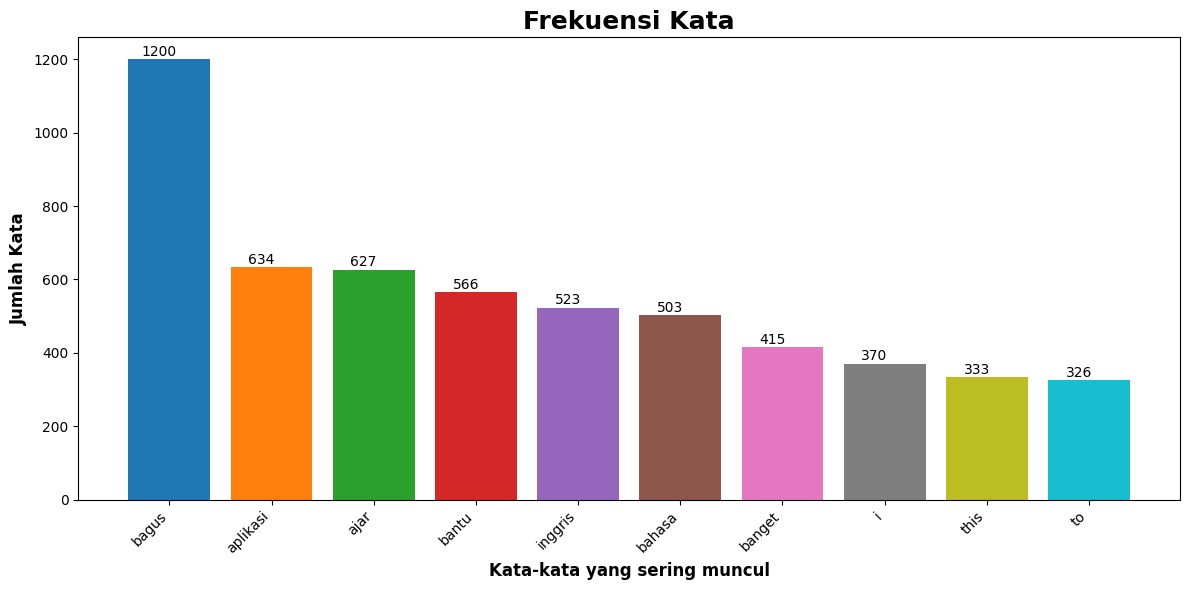

In [53]:
import matplotlib.pyplot as plt
from collections import Counter

text = " ".join(df['stemming'])

tokens = text.split()
word_counts = Counter(tokens)

top_words = word_counts.most_common(10)

word, counts = zip(*top_words)

# definisiin palet warna
colors = plt.cm.tab10(range(len(word)))

plt.figure(figsize=(12, 6))
bars = plt.bar(word, counts, color=colors)
plt.xlabel('Kata-kata yang sering muncul', fontsize=12, fontweight='bold')
plt.ylabel('Jumlah Kata', fontsize=12, fontweight='bold')
plt.title('Frekuensi Kata', fontsize=18, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)

# menambahkan angka rata-rata di tiap bar nya
for bar, num in zip(bars, counts):
  plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, num+1, str(num), color='black', ha='center', va='bottom', fontsize=10)

plt.tight_layout()

## 8. Labelling Data

In [ ]:
import pandas as pd

def label_sentimen(score):
    if score >= 4:
        return "positif"
    elif score <= 2:
        return "negatif"
    else:
        return "netral"

df["label"] = df["score"].apply(label_sentimen)

In [59]:
df

,content,score,tokenize,stopword removal,stemming,label
0,sekarang berbayar semua,1,"[sekarang, berbayar, semua]",[berbayar],bayar,negatif
2,bagus,5,[bagus],[bagus],bagus,positif
3,aplikasi yang sangat luar biasa bisa membantu ...,5,"[aplikasi, yang, sangat, luar, biasa, bisa, me...","[aplikasi, membantu, belajar, bahasa, inggris]",aplikasi bantu ajar bahasa inggris,positif
4,very bagus aplication,5,"[very, bagus, aplication]","[very, bagus, aplication]",very bagus aplication,positif
5,peningkatan secara bertahap,5,"[peningkatan, secara, bertahap]","[peningkatan, bertahap]",tingkat tahap,positif
...,...,...,...,...,...,...
6094,this is so good!!! i love it!,5,"[this, is, so, good, !, !, !, i, love, it, !]","[this, is, so, good, !, !, !, i, love, it, !]",this is so good i love it,positif
6097,this can help me to learn english better.,5,"[this, can, help, me, to, learn, english, bett...","[this, can, help, me, to, learn, english, bett...",this can help me to learn english better,positif
6098,it,4,[it],[it],it,positif
6099,love it!!,5,"[love, it, !, !]","[love, it, !, !]",love it,positif


<ipython-input-65-7406f8ef948b>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sentiment_count.index, y=sentiment_count.values, palette='pastel')


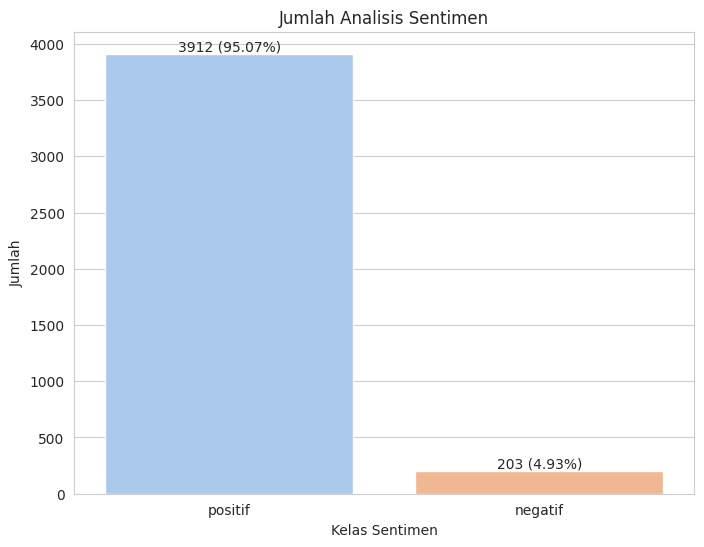

In [65]:
sentiment_count = df['label'].value_counts()
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.barplot(x=sentiment_count.index, y=sentiment_count.values, palette='pastel')
plt.title('Jumlah Analisis Sentimen')
plt.xlabel('Kelas Sentimen')
plt.ylabel('Jumlah')

total = len(df)
for i, count in enumerate(sentiment_count.values):
    ax.text(i, count, f'{count} ({count/total*100:.2f}%)', ha='center', va='bottom')

plt.show()

## Penerapan algoritma

In [78]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Split data
X_train, X_test, y_train, y_test = train_test_split(df['stemming'], df['label'], test_size=0.2, random_state=42)

In [79]:
# menampilkan jumlah data uji dan latih
print("Jumlah data latih:", len(X_train))
print("Jumlah data uji:", len(X_test))

Jumlah data latih: 3292
Jumlah data uji: 823


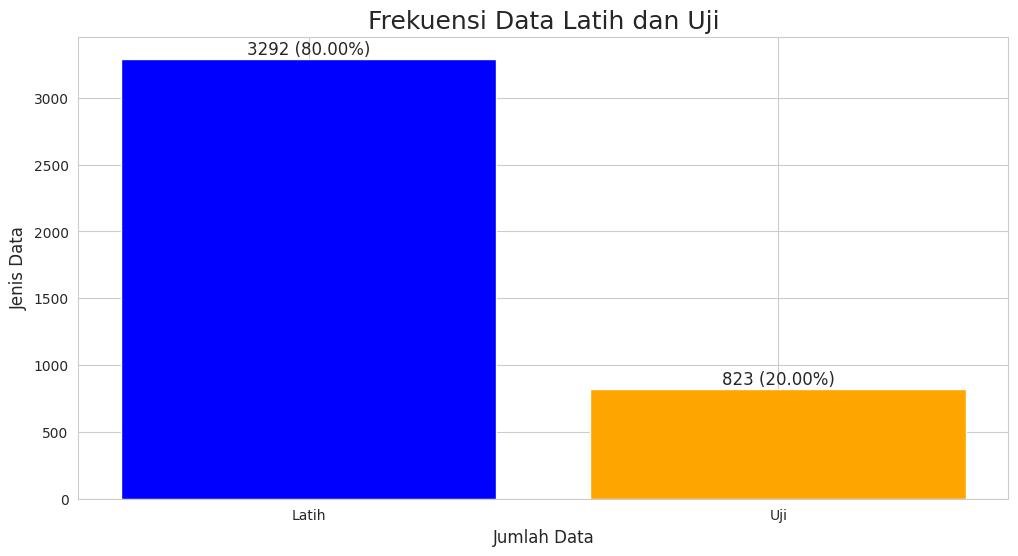

In [80]:
# plot data uji dan latih

plt.figure(figsize=(12, 6))
bars = plt.bar(['Latih', 'Uji'], [len(X_train), len(X_test)], color=['blue', 'orange'])

# tambahin jumlah ke tiap bar dan juga persentase nya (dalam kurung persentase)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height} ({height/total*100:.2f}%)', ha='center', va='bottom', fontsize=12)

plt.xlabel('Jumlah Data', fontsize=12)
plt.ylabel('Jenis Data', fontsize=12)
plt.title('Frekuensi Data Latih dan Uji', fontsize=18)
plt.show()

**SUPPORT VECTOR MACHINE (SVM)**

In [81]:
# mendefinisikan vectorizer
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [83]:
# menampilkan hasil vektorisasi
print("Matriks Vektorisasi untuk data latih")
print(X_train_vectorized)
print("Matriks Vektorisasi untuk data uji")
print(X_test_vectorized)

Matriks Vektorisasi untuk data latih
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 15518 stored elements and shape (3292, 2455)>
  Coords	Values
  (0, 2357)	0.3272138678644724
  (0, 1145)	0.1591584824925408
  (0, 224)	0.3988936843245764
  (0, 1717)	0.23958381519257368
  (0, 1580)	0.3090324645437316
  (0, 2077)	0.17612654978617637
  (0, 118)	0.1157948929916773
  (0, 464)	0.20964581558969583
  (0, 1530)	0.2844511070435198
  (0, 1977)	0.2915478537357816
  (0, 2031)	0.16502916428499012
  (0, 38)	0.31143140519031853
  (0, 1063)	0.3272138678644724
  (0, 482)	0.2645675555889829
  (1, 182)	0.2996132225202859
  (1, 1133)	0.9540607511532008
  (2, 118)	0.5354042548810077
  (2, 1345)	0.8445959293385878
  (3, 1599)	1.0
  (4, 239)	0.3801403136822477
  (4, 47)	0.37956459353654176
  (4, 337)	0.6275492186882428
  (4, 204)	0.40215549515196
  (4, 992)	0.3948126100947893
  (5, 182)	0.34098510778899954
  :	:
  (3286, 1333)	0.41671323626264173
  (3286, 1533)	0.48303957849380186
  (3286, 1985

In [84]:
# Membuat dan melatih model SVM
from sklearn.svm import SVC
svm = SVC(kernel='linear')
svm.fit(X_train_vectorized, y_train)

SVC(kernel='linear')

In [101]:
# Evaluasi
y_pred = svm.predict(X_test_vectorized)
accuracy = accuracy_score(y_test, y_pred)
print("Akurasi model SVM:", accuracy)

acurracy_pred_percentage = accuracy * 100
print("Akurasi model persentase SVM:", "{:.2f}%".format(acurracy_pred_percentage))


Akurasi model SVM: 0.9489671931956257
Akurasi model persentase SVM: 94.90%


In [88]:
# Menampilkan confussion matrix dalam angka
from sklearn.metrics import confusion_matrix
cm_svm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm_svm)

Confusion Matrix:
[[  1  41]
 [  1 780]]


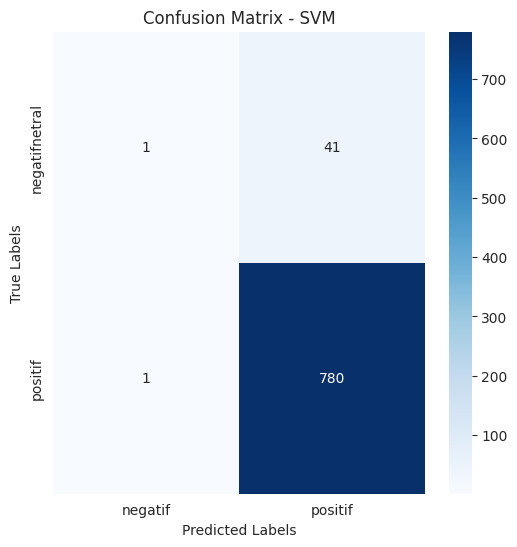

In [96]:
# fungsi untuk confussion matrix
def plot_confusion_matrix(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negatif','positif'], yticklabels=['negatif' 'netral', 'positif'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
plot_confusion_matrix("SVM", y_test, y_pred)

In [100]:
# Menampilkan accuracy untuk SVM
accuracy = accuracy_score(y_test, y_pred)
print("Akurasi model SVM:", accuracy)

accuracy_svm_percentage = accuracy * 100
print("Akurasi model dengan persentase SVM:", "{:.2f}%".format(accuracy_svm_percentage))

# klasifikasi report svm
print("SVM Classification Report: ")
print(classification_report(y_test, y_pred))

Akurasi model SVM: 0.9489671931956257
Akurasi model dengan persentase SVM: 94.90%
SVM Classification Report: 
              precision    recall  f1-score   support

     negatif       0.50      0.02      0.05        42
     positif       0.95      1.00      0.97       781

    accuracy                           0.95       823
   macro avg       0.73      0.51      0.51       823
weighted avg       0.93      0.95      0.93       823

